In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [129]:
import numpy as np
import pandas as pd
from scipy import stats

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
pd.set_option('display.max_rows', 3000)

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


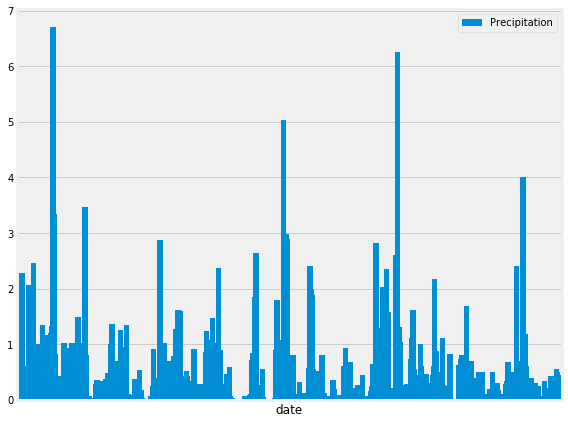

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

latest_dt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(f'Latest date is - {latest_dt}')
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=366)
# print(f'Date from one year ago - {year_ago}')

oneyear_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()
oneyear_data_df = pd.DataFrame(oneyear_data).sort_values(by=['date'], inplace=False, ascending=True).set_index('date')
cleared_df = oneyear_data_df.dropna(how='all', axis=0)

cleared_df.plot(kind='bar',figsize=(8,6), width=20, legend=False)
plt.xticks([], [])
plt.legend(['Precipitation'])
plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
cleared_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [53]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(func.count(Measurement.station.distinct())).all()
count_stations

[(9)]

In [54]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
top_station = session.query(Measurement.station).\
             group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
# engine.execute('select * from Measurement').fetchall()

In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'The lowest temperature recorded of the most active station is {lowest_temp}')
print(f'The highest temperature recorded of the most active station is{highest_temp}')
print(f'The average temperature recorded of the most active station is{avg_temp}')

The lowest temperature recorded of the most active station is [(54.0,)]
The highest temperature recorded of the most active station is[(85.0,)]
The average temperature recorded of the most active station is[(71.66378066378067,)]


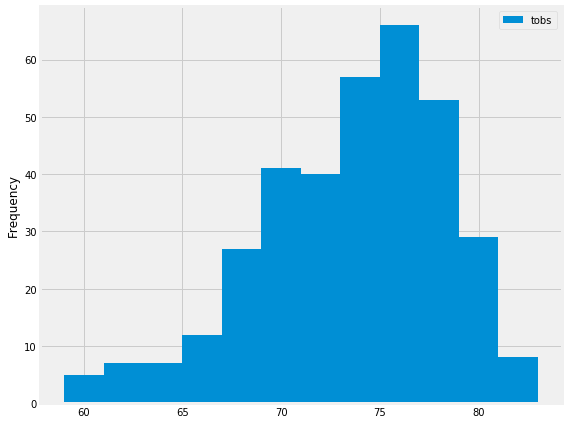

In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
oneyear_tempdata = session.query(Measurement.tobs).\
               filter(Measurement.date > year_ago).\
               filter(Measurement.station == 'USC00519281').all()
oneyear_tempdata_df = pd.DataFrame(oneyear_tempdata)

oneyear_tempdata_df.plot(kind='hist',figsize=(8,6),bins=12)
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [105]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [106]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
summary = calc_temps('2017-02-28','2017-03-05')
summary_list = list(np.ravel(summary))
print(summary_list)

[64.0, 72.02777777777777, 78.0]


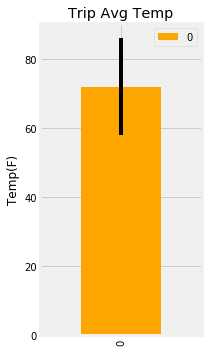

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df = pd.DataFrame([summary_list[1]])
df.plot.bar(figsize=(3,5),color='orange', title='Trip Avg Temp', yerr=[summary_list[2]-summary_list[0]])
plt.ylabel('Temp(F)')
plt.tight_layout()
plt.show()


In [119]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data = session.query(Measurement.station,func.sum(Measurement.prcp),Station.name,Station.longitude,Station.latitude,Station.elevation).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date >= "2016-8-23").filter(Measurement.date <= "2017-8-23").\
                group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
data

[('USC00516128',
  68.78000000000003,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519281',
  43.66000000000002,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00513117',
  34.62000000000001,
  'KANEOHE 838.1, HI US',
  -157.8015,
  21.4234,
  14.6),
 ('USC00519523',
  27.319999999999993,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5),
 ('USC00514830',
  21.80000000000002,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00519397',
  10.659999999999993,
  'WAIKIKI 717.2, HI US',
  -157.8168,
  21.2716,
  3.0),
 ('USC00517948', 3.39, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9)]

## Optional Challenge Assignment

In [159]:
# Temperature Analysis I
# Identify the average temperature in June at all stations across all available years in the dataset.
# Do the same for December temperature.
# Use the t-test to determine whether the difference in the means, if any, is statistically significant.
# Will you use a paired t-test, or an unpaired t-test? Why?
june = session.query(func.avg(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    filter(func.strftime("%m", Measurement.date) == "06").all()

december = session.query(func.avg(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    filter(func.strftime("%m", Measurement.date) == "12").all()

june_df = pd.DataFrame(june, columns = {'tobs'})
december_df = pd.DataFrame(december, columns = {'tobs'})

print("We will use paired t-test because we comparing samples from the same dataset  ")
# Run T test
# (t_stat, p) = stats.ttest_ind(june_df, december_df, equal_var=False)
(t_stat, p) = stats.ttest_rel(june_df, december_df)
print("t-statistics is {}.".format(t_stat))
print("p-value is {}.".format(p))
# stats.describe(june_df)
# stats.describe(december_df)
# june_df

t-statistics is [6.95696617].
p-value is [0.00011759].


In [62]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start = datetime.datetime.strptime("02-28-2017", "%m-%d-%Y")
end = datetime.datetime.strptime("03-06-2017", "%m-%d-%Y")    

# Use the start and end date to create a range of dates
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

# Stip off the year and save a list of %m-%d strings
date_ranges = []
for date in date_generated:
    dates = date.strftime("%m-%d-%Y")
    date_ranges.append(dates)
# print(date_ranges)     

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_min = []
daily_normals_avg = []
daily_normals_max = []
for date in date_generated:
    x = np.ravel(daily_normals(date.strftime("%m-%d")))
    daily_normals_min.append(x[0])
    daily_normals_avg.append(x[1])
    daily_normals_max.append(x[2])
print(daily_normals_min)
print(daily_normals_avg)
print(daily_normals_max)

[65.0, 64.0, 61.0, 60.0, 57.0, 60.0]
[70.65517241379311, 70.0327868852459, 70.36666666666666, 70.06896551724138, 69.27272727272727, 67.89090909090909]
[80.0, 76.0, 78.0, 78.0, 77.0, 76.0]


In [67]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({'tmin': daily_normals_min,
                   'tavg': daily_normals_avg,
                   'tmax': daily_normals_max}, index=date_ranges)
df    

,tmin,tavg,tmax
02-28-2017,65.0,70.655172,80.0
03-01-2017,64.0,70.032787,76.0
03-02-2017,61.0,70.366667,78.0
03-03-2017,60.0,70.068966,78.0
03-04-2017,57.0,69.272727,77.0
03-05-2017,60.0,67.890909,76.0


Text(0.5, 0, 'Date')

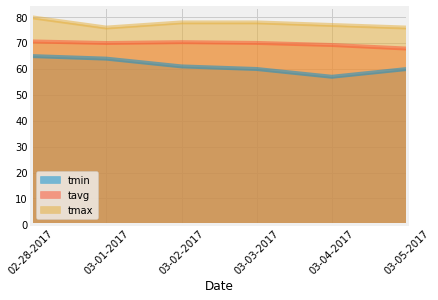

In [68]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False,rot=45)
plt.xlabel('Date')